## BACKTESTING STRATEGIES

### 2. DCA variable (frecuencia semanal): Cuando el retorno sube mas de un 5% no se compra esa semana, cuando el retorno baja mas de un 5%, se duplica la inversión de usdt.

In [237]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from datetime import datetime, date, timedelta
import math
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()
sns.set_theme()



In [238]:
# Lectura de datos
start = datetime(1900,1,1)
end = datetime.now()
data = pdr.get_data_yahoo('BTC-USD', start, end, interval='d')
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2021-11-17,60823.609375,58515.410156,60139.621094,60368.011719,3.917839e+10,60368.011719
2021-11-18,60948.500000,56550.792969,60360.136719,56942.136719,4.138834e+10,56942.136719
2021-11-19,58351.113281,55705.179688,56896.128906,58119.578125,3.870241e+10,58119.578125


In [239]:
# Crear variables y subset para análisis
df = data[['Adj Close']]['2017':'2021'].copy()
df = df.rename(columns={'Adj Close': 'btc_price'})
df['btc_return'] = df['btc_price'].pct_change()
df['day'] = df.index.day
df['weekday'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df.head()

,btc_price,btc_return,day,weekday,month,year
Date,,,,,,
2017-01-01,998.325012,NaN,1,6,1,2017
2017-01-02,1021.750000,0.023464,2,0,1,2017
2017-01-03,1043.839966,0.021620,3,1,1,2017
2017-01-04,1154.729980,0.106233,4,2,1,2017
2017-01-05,1013.380005,-0.122410,5,3,1,2017


In [240]:
def cagr(df):
    """
    cagr [retorna el CAGR en un DataFrame]
    [Una tasa de crecimiento anual compuesto (CAGR) mide la tasa de retorno de una inversión (como un fondo de inversión o un bono) durante un período de inversión, como 5 o 10 años]
    Args:
        df ([DataFrame]): [DataFrame obtenido al leer los datos del activo de interés]
    """
    df = df.copy()
    df = df.sort_index(ascending=True)
    df['cum_return'] = (1 + df['btc_return']).cumprod()
    total_ret = df['cum_return'][-1]

    start = datetime.utcfromtimestamp(df.index.values[0].astype('O')/1e9)
    end = datetime.utcfromtimestamp(df.index.values[-1].astype('O')/1e9)
    period_years = (end - start).days / 365.25
    CAGR = (total_ret)**(1/period_years)-1
    return CAGR

In [241]:

def DCA_variable(df, usdt, var_usdt):
   '''
   Retorna un dataframe con la cantidad de usdt invertidos (según la variación del retorno) y la cantidad de btc obtenidos.
   '''
   for x in df.index:
      row = df.loc[x]
      if(row['btc_return'] < -(0.05)):
         df.at[x,'usdt_invested'] = usdt*(1+var_usdt)
      elif(row['btc_return'] > 0.05):    
         df.at[x,'usdt_invested'] = usdt*(1-var_usdt)
      else:
         df.at[x, 'usdt_invested'] = usdt
   df['btc_amount'] = df_sem['usdt_invested']/df_sem['btc_price']
   return df.head(20)
    

In [242]:
#Estrategia aplicando DCA variable
df_sem = df[df['weekday']==1]
df_sem['btc_return'] = df_sem['btc_price'].pct_change()
DCA_variable(df_sem, 50,1)

,btc_price,btc_return,day,weekday,month,year,usdt_invested,btc_amount
Date,,,,,,,,
2017-01-03,1043.839966,NaN,3,1,1,2017,50.0,0.047900
2017-01-10,907.679016,-0.130442,10,1,1,2017,100.0,0.110171
2017-01-17,907.937988,0.000285,17,1,1,2017,50.0,0.055070
2017-01-24,892.687012,-0.016797,24,1,1,2017,50.0,0.056011
2017-01-31,970.403015,0.087059,31,1,1,2017,0.0,0.000000
2017-02-07,1061.349976,0.093721,7,1,2,2017,0.0,0.000000
2017-02-14,1004.549988,-0.053517,14,1,2,2017,100.0,0.099547
2017-02-21,1115.300049,0.110248,21,1,2,2017,0.0,0.000000
2017-02-28,1179.969971,0.057984,28,1,2,2017,0.0,0.000000


In [243]:
total_btc_amount = df_sem['btc_amount'].sum()
total_usdt_invested = df_sem['usdt_invested'].sum()
total_usdt_obtained = round(total_btc_amount*df['btc_price'][-1],3)
total_return = (total_usdt_obtained/total_usdt_invested-1)*100
cagr_value = cagr(df_sem)
print(f'total_return: {round(total_return,2)}%')
print(f'total_usdt_invested: {total_usdt_invested}')
print(f'total_usdt_obtained: {total_usdt_obtained}')
print(f'cagr: {round(cagr_value,2)}')

total_return: 1002.96%
total_usdt_invested: 11450.0
total_usdt_obtained: 126288.794
cagr: 1.3


In [244]:
usdt_variation = list(np.linspace(0,1,10))
initial_usdt = []
final_usdt = []
usdt_return = []
cagr_value = []

for j in usdt_variation:
    DCA_variable(df_sem, 50, j)
    total_btc_amount = df_sem['btc_amount'].sum()
    total_usdt_invested = df_sem['usdt_invested'].sum()
    total_usdt_obtained = round(total_btc_amount*df['btc_price'][-1],3)
    total_return = (total_usdt_obtained/total_usdt_invested-1)*100
    
    #metrics
    total_btc_amount = df_sem['btc_amount'].sum()
    
    total_usdt_invested = df_sem['usdt_invested'].sum()
    initial_usdt.append(total_usdt_invested)
    
    total_usdt_obtained = round(total_btc_amount*df['btc_price'][-1],3)
    final_usdt.append(round(total_usdt_obtained,1))

    total_return = (total_usdt_obtained/total_usdt_invested-1)*100
    usdt_return.append(round(total_return,2))

    btc_cagr = cagr(df_sem)
    cagr_value.append(btc_cagr)

usdt_variation = pd.DataFrame(usdt_variation, columns=['usdt_var'])
initial_usdt = pd.DataFrame(initial_usdt, columns=['total_usdt_invested'])
final_usdt = pd.DataFrame(final_usdt, columns=['total_usdt_obtained'])
usdt_return = pd.DataFrame(usdt_return, columns=['total_return'])
cagr_value = pd.DataFrame(cagr_value, columns=['cagr'])

resultados = pd.concat([usdt_variation, initial_usdt, final_usdt, usdt_return, cagr_value], axis=1)
resultados
    

,usdt_var,total_usdt_invested,total_usdt_obtained,total_return,cagr
0,0.000000,12700.000000,138444.0,990.11,1.299813
1,0.111111,12561.111111,137093.4,991.41,1.299813
2,0.222222,12422.222222,135742.8,992.74,1.299813
3,0.333333,12283.333333,134392.2,994.10,1.299813
4,0.444444,12144.444444,133041.7,995.49,1.299813
5,0.555556,12005.555556,131691.1,996.92,1.299813
6,0.666667,11866.666667,130340.5,998.38,1.299813
7,0.777778,11727.777778,128989.9,999.87,1.299813
8,0.888889,11588.888889,127639.4,1001.39,1.299813
9,1.000000,11450.000000,126288.8,1002.96,1.299813


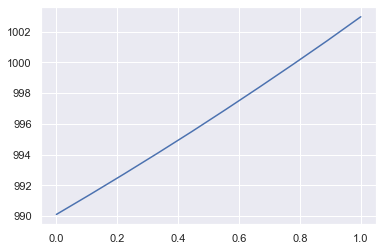

In [245]:
plt.plot(resultados['usdt_var'], resultados['total_return'], label = 'total_return')

In [246]:
print(f'return: {resultados["total_return"].max()}')
print(f'cagr: {resultados["cagr"].max()}')

return: 1002.96
cagr: 1.2998133615240484
